# 1. Import libraries

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

print("Libraries loaded successfully!")

Libraries loaded successfully!


# 2. Data Exploratory Analysis

## 2.1 Data exploration

In [77]:
data = pd.read_csv("/kaggle/input/national-anthems-of-the-world/anthems.csv")
data.head()

,Country,Alpha-2,Alpha-3,Continent,Anthem
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish..."
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo..."
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ..."
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan..."
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea..."


In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Country    190 non-null    object
 1   Alpha-2    189 non-null    object
 2   Alpha-3    190 non-null    object
 3   Continent  190 non-null    object
 4   Anthem     190 non-null    object
dtypes: object(5)
memory usage: 7.5+ KB


In [79]:
data.shape

(190, 5)

In [80]:
data.describe(include='all')

,Country,Alpha-2,Alpha-3,Continent,Anthem
count,190,189,190,190,190
unique,190,188,190,6,188
top,Albania,CH,ALB,Africa,"Arise, ye who refuse to be slaves; With our ve..."
freq,1,2,1,56,2


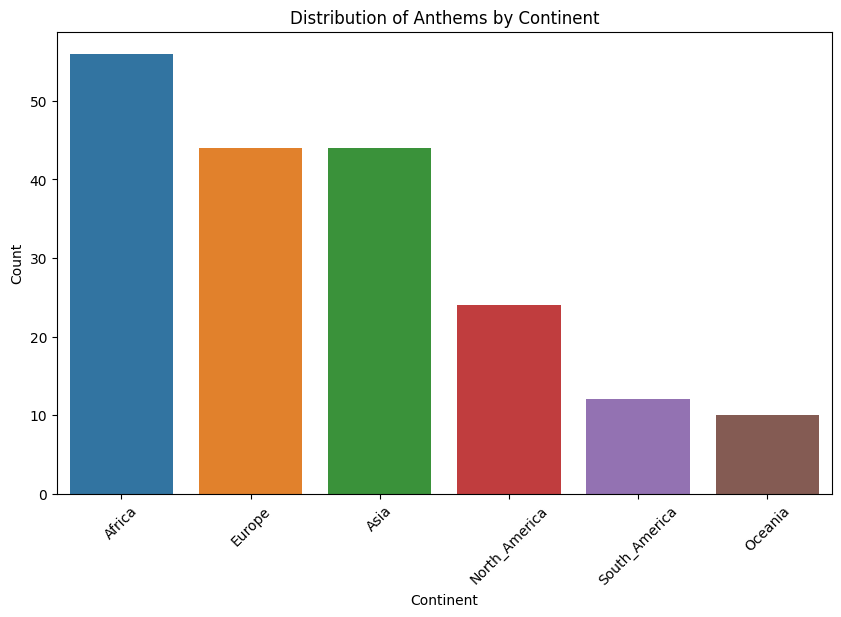

In [81]:
# Distribution of continents
plt.figure(figsize=(10, 6))
continent_dist = data['Continent'].value_counts()
sns.barplot(x=continent_dist.index, y=continent_dist.values)
plt.title('Distribution of Anthems by Continent')
plt.xlabel('Continent')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## 2.2 Missing values

In [82]:
data.isnull().sum()

Country      0
Alpha-2      1
Alpha-3      0
Continent    0
Anthem       0
dtype: int64

In [83]:
data[data.isnull().any(axis=1)]

,Country,Alpha-2,Alpha-3,Continent,Anthem
168,Namibia,NaN,NAM,Africa,Namibia land of the brave Freedom fight we he ...


From exploring the only 1 missing value. We can see that there's only abbreviation of the country in the column "Alpha-2". So, I would fill it with the same one as Alpha-3.

In [84]:
data = data.fillna("NAM")
data.isnull().sum()

Country      0
Alpha-2      0
Alpha-3      0
Continent    0
Anthem       0
dtype: int64

There we go. Outliers is gone now . Easy peasy:)

## 2.3 Outliers

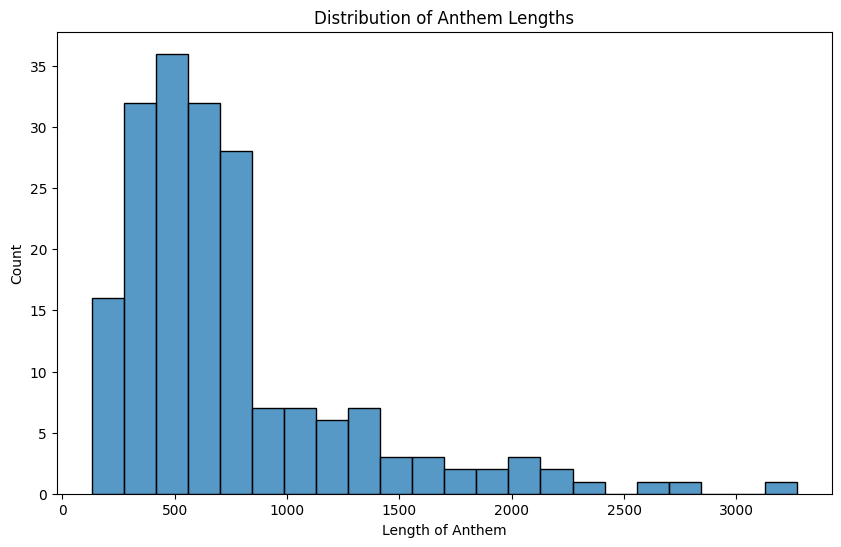

In [85]:
data['Anthem_Length'] = data['Anthem'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(data['Anthem_Length'])
plt.title('Distribution of Anthem Lengths')
plt.xlabel('Length of Anthem')
plt.show()

In [86]:
# Calculate IQR and bounds for outlier detection
Q1 = data['Anthem_Length'].quantile(0.25)
Q3 = data['Anthem_Length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = data[(data['Anthem_Length'] < lower_bound) | (data['Anthem_Length'] > upper_bound)]
normal_data = data[(data['Anthem_Length'] >= lower_bound) & (data['Anthem_Length'] <= upper_bound)]

# Print outlier statistics
print("\nOutlier Analysis for Anthem Lengths:")
print(f"Q1: {Q1:.2f}")
print(f"Q3: {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")
print(f"\nNumber of outliers: {len(outliers)}")
print(f"Percentage of outliers: {(len(outliers)/len(data)*100):.2f}%")


Outlier Analysis for Anthem Lengths:
Q1: 418.50
Q3: 833.00
IQR: 414.50
Lower bound: -203.25
Upper bound: 1454.75

Number of outliers: 19
Percentage of outliers: 10.00%


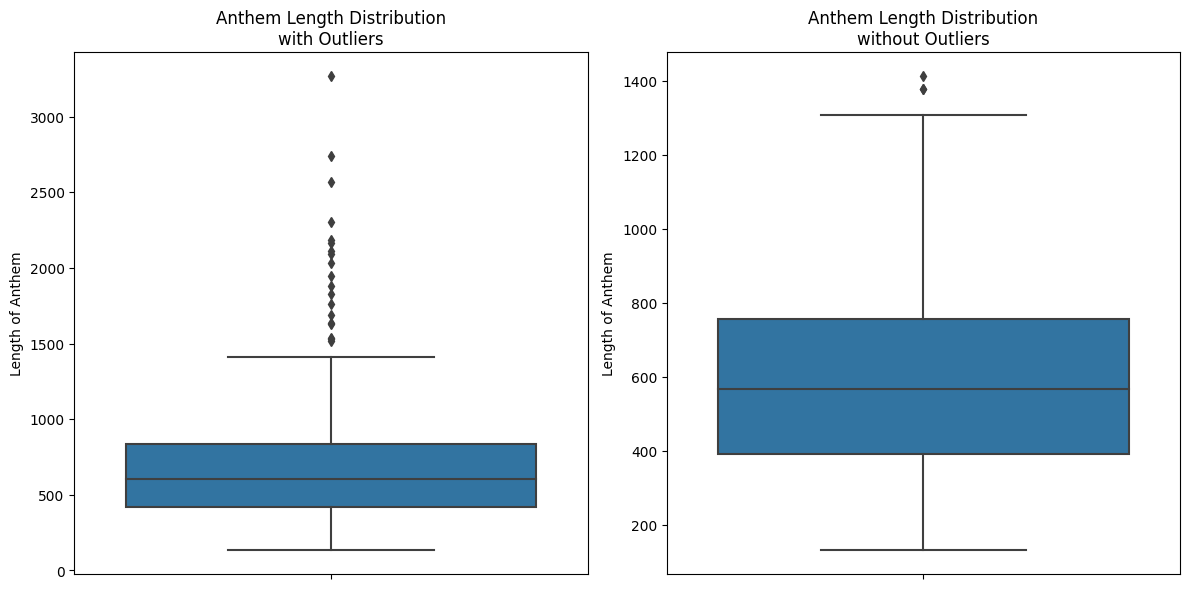

In [87]:
# Boxplot with outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=data['Anthem_Length'])
plt.title('Anthem Length Distribution\nwith Outliers')
plt.ylabel('Length of Anthem')

# Boxplot without outliers
plt.subplot(1, 2, 2)
sns.boxplot(y=normal_data['Anthem_Length'])
plt.title('Anthem Length Distribution\nwithout Outliers')
plt.ylabel('Length of Anthem')
plt.tight_layout()
plt.show()

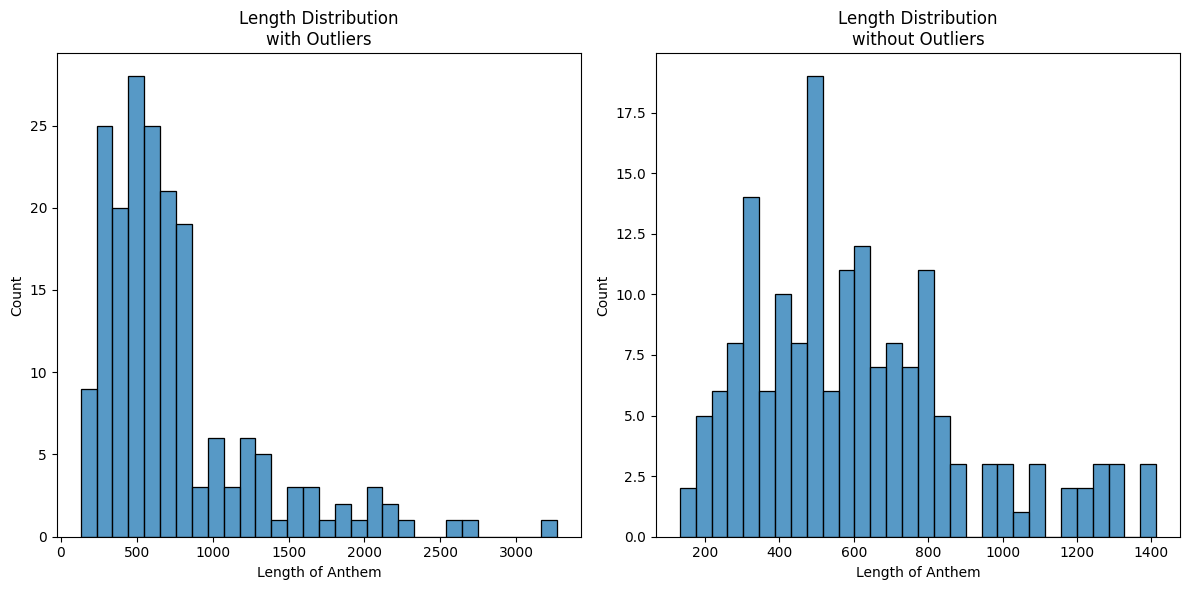

In [88]:
# Histogram with outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=data, x='Anthem_Length', bins=30)
plt.title('Length Distribution\nwith Outliers')
plt.xlabel('Length of Anthem')

# Histogram without outliers
plt.subplot(1, 2, 2)
sns.histplot(data=normal_data, x='Anthem_Length', bins=30)
plt.title('Length Distribution\nwithout Outliers')
plt.xlabel('Length of Anthem')

plt.tight_layout()
plt.show()

In [89]:
data_cleaned = data[(data['Anthem_Length'] >= lower_bound) & (data['Anthem_Length'] <= upper_bound)].copy()

print("\nDataset shape before outlier removal:", data.shape)
print("Dataset shape after outlier removal:", data_cleaned.shape)

# Summary statistics comparison
print("\nSummary statistics comparison:")
print("\nWith outliers:")
print(data['Anthem_Length'].describe())
print("\nWithout outliers:")
print(data_cleaned['Anthem_Length'].describe())


Dataset shape before outlier removal: (190, 6)
Dataset shape after outlier removal: (171, 6)

Summary statistics comparison:

With outliers:
count     190.000000
mean      748.510526
std       525.170547
min       132.000000
25%       418.500000
50%       602.500000
75%       833.000000
max      3268.000000
Name: Anthem_Length, dtype: float64

Without outliers:
count     171.000000
mean      606.918129
std       287.476616
min       132.000000
25%       392.000000
50%       567.000000
75%       758.000000
max      1413.000000
Name: Anthem_Length, dtype: float64


## 2.4 Translating to Thai language

In [90]:
!pip install transformers torch sentencepiece
!pip install transformers==4.20
!pip install googletrans==4.0.0-rc1

In [91]:
from googletrans import Translator

translator = Translator()
data_cleaned['Anthem_thai'] = data['Anthem'].apply(lambda x: translator.translate(x, dest='th').text)

In [98]:
data_cleaned[['Anthem', 'Anthem_thai']].head(20)

,Anthem,Anthem_thai
0,"Around our flag we stand united, With one wish...",รอบธงของเราเรายืนเป็นหนึ่งเดียวด้วยความปรารถนา...
1,"Our Fatherland, free, independent, That has fo...",บ้านเกิดของเราฟรีอิสระที่มีมานานหลายศตวรรษแล้ว...
2,"Land of mountains, land by the river, Land of ...","ดินแดนแห่งภูเขา, ที่ดินริมแม่น้ำ, ดินแดนแห่งทุ..."
3,"Azerbaijan, Azerbaijan! The glorious Fatherlan...",อาเซอร์ไบจานอาเซอร์ไบจาน!พ่อแม่อันรุ่งโรจน์ของ...
4,"We, Belarusians, are peaceful people, Wholehea...",พวกเราชาวเบลารุสเป็นคนที่สงบสุขอุทิศให้กับมาตุ...
5,"O dear Belgium, O holy land of the fathers Ã¢â...",o เบลเยี่ยมที่รัก O ดินแดนศักดิ์สิทธิ์ของบรรพบ...
6,You're the light of the soul Eternal fire's fl...,คุณคือแสงแห่งเปลวไฟแห่งไฟแห่งวิญญาณของเรา O La...
7,"Proud Balkan Mountains, next to it the Danube ...",Proud Balkan Mountains ถัดจากนั้น Danube Spark...
8,"Our beautiful homeland, Oh so fearless and gra...",บ้านเกิดที่สวยงามของเราโอ้อย่างไม่เกรงกลัวและส...
9,"We knew thee of old, O, divinely restored, By ...",เรารู้ว่าเจ้าเก่าแก่ได้รับการบูรณะอย่างเป็นพระ...


We can see at the column 5,6,7. The translator doesn't perform the meaning perfectly. So, if we need more precise for the translation. We need to modify more.

# 3. Test Preprocessing and Scaling

In [93]:
# Create TF-IDF features
print("\nCreating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
text_features = tfidf.fit_transform(data_cleaned['Anthem'])

# Scale features
scaler = StandardScaler(with_mean=False)
scaled_features = scaler.fit_transform(text_features)

print("Feature shape:", scaled_features.shape)
print("Top features:", tfidf.get_feature_names_out()[:10])


Creating TF-IDF features...
Feature shape: (171, 100)
Top features: ['africa' 'ancestors' 'arise' 'beautiful' 'beloved' 'bless' 'blood'
 'brave' 'brothers' 'canada']


# 4. K-Means Clustering

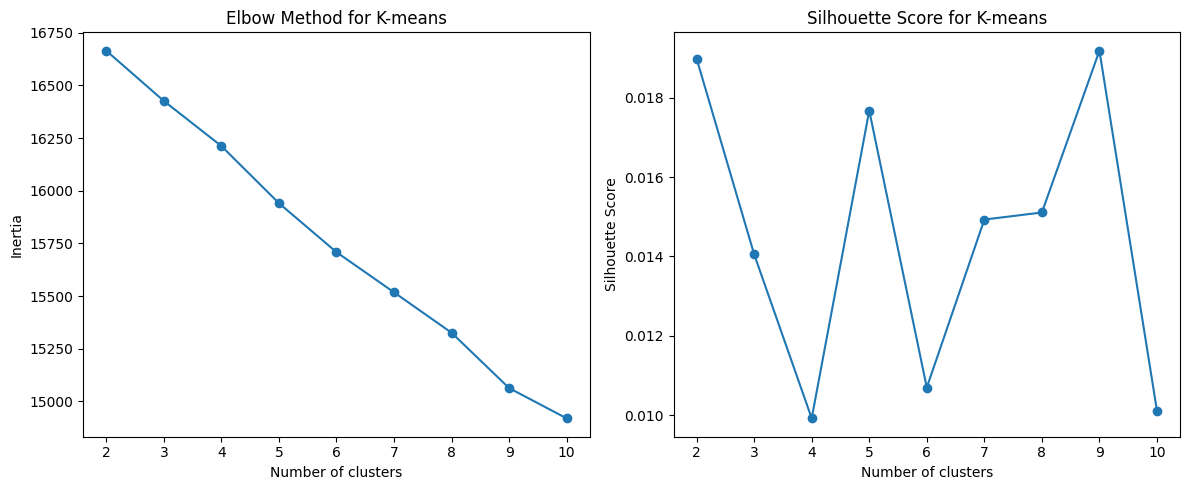

In [94]:
max_clusters = 10
inertias = []
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Plot elbow curve and silhouette scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), inertias, marker='o')
plt.title('Elbow Method for K-means')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Score for K-means')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

In [95]:
# Find optimal number of clusters
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"\nOptimal number of clusters (K-means): {optimal_k} clusters")

# Apply K-means with optimal number of clusters
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data_cleaned['Cluster_KMeans'] = final_kmeans.fit_predict(scaled_features)

# Print cluster distribution
print("\nK-means Cluster Distribution:")
print(data_cleaned['Cluster_KMeans'].value_counts())


Optimal number of clusters (K-means): 9 clusters

K-means Cluster Distribution:
Cluster_KMeans
1    42
3    32
0    19
4    17
6    16
2    16
7    15
5    13
8     1
Name: count, dtype: int64


# 5. Hierarchical Clustering

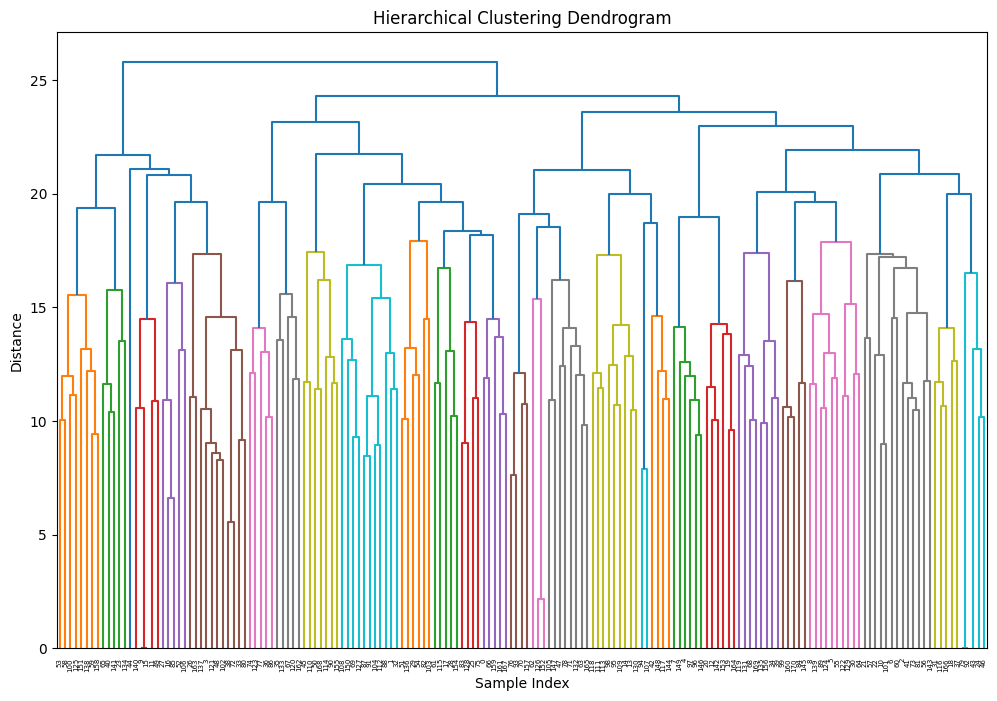

In [96]:
# Create linkage matrix
linkage_matrix = linkage(scaled_features.toarray(), method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# 6. Results Analysis

In [97]:
print("\nSample anthems from each cluster:")
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    sample_countries = data_cleaned[data_cleaned['Cluster_KMeans'] == cluster]['Country'].head(10)
    print("Countries:", ', '.join(sample_countries))


Sample anthems from each cluster:

Cluster 0:
Countries: Belarus, Bulgaria, Georgia, Latvia, Romania, Trinidad and Tobago, Grenada, Bhutan, Malaysia, Myanmar

Cluster 1:
Countries: Austria, Azerbaijan, Croatia, Czechia, Estonia, Iceland, Italy, Montenegro, Norway, Serbia

Cluster 2:
Countries: Germany, Ireland, Liechtenstein, Poland, Portugal, Sweden, Puerto Rico, Bahamas, China, Macau

Cluster 3:
Countries: Lithuania, Luxembourg, Panama, Barbados, Bermuda, Australia, Vanuatu, Kiribati, Federated States of Micronesia, Bahrain

Cluster 4:
Countries: Russian Federation (the), Spain, Haiti, Greenland, Samoa, Cambodia, Iran, Iraq, Jordan, Kazakhstan

Cluster 5:
Countries: Albania, Malta, Netherlands (the), Slovenia, United Kingdom of Great Britain and Northern Ireland (the), New Zealand, Fiji, Solomon Islands, Equatorial Guinea, Ghana

Cluster 6:
Countries: Armenia, Venezuela, Cuba, Saint Lucia, Mongolia, North Korea, Singapore, Tajikistan, Turkmenistan, Uzbekistan

Cluster 7:
Countries: 